# Read in Census and SD data
# Build dataframe of scaled features and scaled labels (i.e., median number of days businesses have been open in each tract)
## Add in some dummy variables for simplified NAICS code
## Add in some interaction terms

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## Labels

In [2]:
# read in labels (i.e., business info)
bus = pd.read_csv('data_final/sd_active_businesses_cleaned.csv')
print len(bus)
bus[:5]

56710


,account_key,doing_bus_as_name,days_since_creation,naics_code,naics_code_simple,census_tract
0,2016008533,ARCHITECT ATHLETICS,61,42199,42,3212
1,2016008531,SILVER LINING STAGERS,61,54149,54,8335
2,2016008529,TAMKEEN INC,61,42299,42,8511
3,2016008525,REBECCA EICHTEN ART DESIGN,61,45311,45,900
4,2016008524,COLD STONE CREAMERY 20837,61,72221,72,7905


In [3]:
# get median days since creation for each tract
tracts_age = bus.groupby('census_tract').median().days_since_creation
tracts = tracts_age.index
median_days_open = tracts_age.values
print tracts
print median_days_open[0:10]
print len(tracts)

Int64Index([  100,   201,   202,   300,   400,   500,   600,   700,   800,
              900,
            ...
            20404, 20706, 20707, 20709, 20710, 21100, 21302, 21400, 21500,
            21800],
           dtype='int64', name=u'census_tract', length=314)
[ 3751.   3726.5  3751.   3374.   3579.5  3123.5  2708.   3106.   2527.
  1874. ]
314


7.77073990053
8.19452054795
2.51032964193


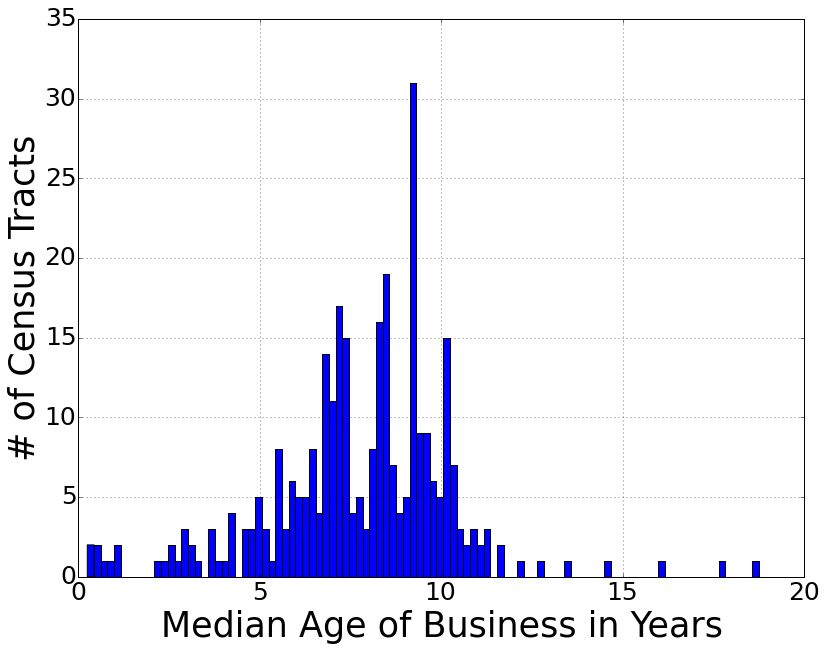

In [4]:
# plot histogram of median days since creation
plt.figure(figsize=(13, 10))
(tracts_age/365).hist(bins=100)
plt.xlabel('Median Age of Business in Years',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)
plt.tick_params(axis='both', which='major', labelsize=25)

# print some stats of ages
print np.mean(tracts_age/365)
print np.median(tracts_age/365)
print np.std(tracts_age/365)

[ 0.54187629  0.53825096  0.54187629  0.48609056  0.51649896  0.44902338
  0.38754069  0.44643386  0.36075762  0.2641314 ]
1.0
0.0
0.40652856817
0.429416987274
0.135583059974


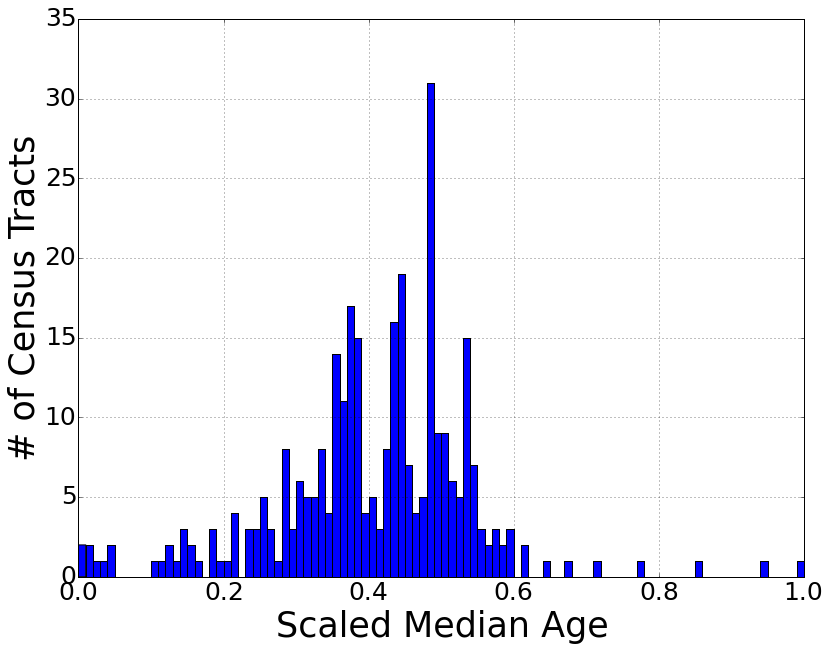

In [5]:
# scale labels to 0-1
median_days_open_scaled = (median_days_open-min(median_days_open)) / (max(median_days_open)-min(median_days_open))
print median_days_open_scaled[:10]
print max(median_days_open_scaled)
print min(median_days_open_scaled)

# plot new histogram
plt.figure(figsize=(13, 10))
plt.hist(median_days_open_scaled,bins=100)
plt.xlabel('Scaled Median Age',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.grid()

# print some stats of scaled ages
print np.mean(median_days_open_scaled)
print np.median(median_days_open_scaled)
print np.std(median_days_open_scaled)

## Features

In [6]:
# define list of simple NAICS business codes
codes = [11,21,22,23,31,32,33,42,44,45,48,49,51,52,53,54,55,56,61,62,71,72,81,92]
print len(codes)

# get counts of each simple business code in each tract
counts = bus.groupby(['census_tract','naics_code_simple']).size()

# initialize matrix of business counts per tract
counts_matrix = np.zeros((len(tracts),len(codes)))
i = 0
j = 0

# go through each tract
for tract in tracts:
    # go through each simple code
    for code in codes:
        # see if the current combination of tract and code exists
        if (tract,code) in counts:
            # save count
            counts_matrix[i,j] = counts[(tract,code)]
        j += 1
    i += 1
    j = 0
print counts_matrix[:10,:]
print counts[:33]

24
[[   1.    0.    0.    5.    0.    0.    1.    4.    2.    8.    0.    0.
     2.    3.   11.   58.    1.    4.    6.    8.    3.    6.   10.    0.]
 [   0.    0.    0.    6.    0.    0.    1.    0.    9.    7.    1.    0.
     3.    4.    9.   47.    0.    2.    7.   17.    7.    7.   55.    0.]
 [   1.    0.    0.   10.    0.    0.    0.    4.    8.   12.    0.    0.
     5.    2.    9.   61.    2.    6.    7.   11.    6.   12.   28.    0.]
 [   1.    0.    0.    7.    2.    1.    4.    2.   23.   19.    7.    0.
     5.    5.   23.   96.    4.   10.   11.  104.    9.   36.  124.    0.]
 [   0.    0.    0.    4.    1.    0.    1.    6.   24.   21.    2.    0.
     5.   10.   23.   60.    2.   14.   10.  154.    9.   39.   95.    0.]
 [   0.    0.    0.    5.    2.    0.    0.    2.    8.   13.    1.    0.
     3.    5.    8.   61.    3.    5.    9.   25.    8.   10.   34.    0.]
 [   0.    0.    0.    5.    1.    0.    0.    3.   19.   14.    1.    0.
     6.    5.    9.   39.    

In [7]:
# save total # of businesses in each tract
n_bus_all = bus.groupby('census_tract').count().account_key
print n_bus_all[:10]

census_tract
100    133
201    182
202    184
300    493
400    480
500    202
600    251
700    214
800    134
900    235
Name: account_key, dtype: int64


In [8]:
print len(tracts)
print len(median_days_open_scaled)
print len(n_bus_all)
print counts_matrix.shape

314
314
314
(314, 24)


In [9]:
# combine feaures from business info into a dataframe
bus_features = pd.DataFrame({'bus_age': median_days_open_scaled, 'n_business': n_bus_all, \
                             'n_businesses_'+str(codes[0]): counts_matrix[:,0], \
                             'n_businesses_'+str(codes[1]): counts_matrix[:,1], \
                             'n_businesses_'+str(codes[2]): counts_matrix[:,2], \
                             'n_businesses_'+str(codes[3]): counts_matrix[:,3], \
                             'n_businesses_'+str(codes[4]): counts_matrix[:,4], \
                             'n_businesses_'+str(codes[5]): counts_matrix[:,5], \
                             'n_businesses_'+str(codes[6]): counts_matrix[:,6], \
                             'n_businesses_'+str(codes[7]): counts_matrix[:,7], \
                             'n_businesses_'+str(codes[8]): counts_matrix[:,8], \
                             'n_businesses_'+str(codes[9]): counts_matrix[:,9], \
                             'n_businesses_'+str(codes[10]): counts_matrix[:,10], \
                             'n_businesses_'+str(codes[11]): counts_matrix[:,11], \
                             'n_businesses_'+str(codes[12]): counts_matrix[:,12], \
                             'n_businesses_'+str(codes[13]): counts_matrix[:,13], \
                             'n_businesses_'+str(codes[14]): counts_matrix[:,14], \
                             'n_businesses_'+str(codes[15]): counts_matrix[:,15], \
                             'n_businesses_'+str(codes[16]): counts_matrix[:,16], \
                             'n_businesses_'+str(codes[17]): counts_matrix[:,17], \
                             'n_businesses_'+str(codes[18]): counts_matrix[:,18], \
                             'n_businesses_'+str(codes[19]): counts_matrix[:,19], \
                             'n_businesses_'+str(codes[20]): counts_matrix[:,20], \
                             'n_businesses_'+str(codes[21]): counts_matrix[:,21], \
                             'n_businesses_'+str(codes[22]): counts_matrix[:,22], \
                             'n_businesses_'+str(codes[23]): counts_matrix[:,23],}, index=tracts)
bus_features[:5]

,bus_age,n_business,n_businesses_11,n_businesses_21,n_businesses_22,n_businesses_23,n_businesses_31,n_businesses_32,n_businesses_33,n_businesses_42,...,n_businesses_53,n_businesses_54,n_businesses_55,n_businesses_56,n_businesses_61,n_businesses_62,n_businesses_71,n_businesses_72,n_businesses_81,n_businesses_92
census_tract,,,,,,,,,,,,,,,,,,,,,
100,0.541876,133,1.0,0.0,0.0,5.0,0.0,0.0,1.0,4.0,...,11.0,58.0,1.0,4.0,6.0,8.0,3.0,6.0,10.0,0.0
201,0.538251,182,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,...,9.0,47.0,0.0,2.0,7.0,17.0,7.0,7.0,55.0,0.0
202,0.541876,184,1.0,0.0,0.0,10.0,0.0,0.0,0.0,4.0,...,9.0,61.0,2.0,6.0,7.0,11.0,6.0,12.0,28.0,0.0
300,0.486091,493,1.0,0.0,0.0,7.0,2.0,1.0,4.0,2.0,...,23.0,96.0,4.0,10.0,11.0,104.0,9.0,36.0,124.0,0.0
400,0.516499,480,0.0,0.0,0.0,4.0,1.0,0.0,1.0,6.0,...,23.0,60.0,2.0,14.0,10.0,154.0,9.0,39.0,95.0,0.0


In [10]:
# read in other features
popl = pd.read_csv('data_final/sd_population_cleaned.csv',index_col=0)
fin = pd.read_csv('data_final/sd_housing_employment_income_cleaned.csv',index_col=0)
parking_meters = pd.read_csv('data_final/sd_parking_meters_cleaned.csv',index_col=0)

# choose which features to use (per census tract)
    # n_business (total number of businesses)
    # n_business_NN (total number of businesses with simple NAICS code NN -- there are 24 of these == len(codes))
    # population (population)
    # population_percent_male
    # population_percent_female
    # age_med (median age)
    # age_med_male (median male age)
    # age_med_female (median female age)
    # minor_percent (percenage under 18)
    # adult_percent (percentage over 18)
    # homes (number of homes)
    # homes_percent_mortgage (percentage of homes owne w/ mortgage)
    # homes_percent_clear (percentage of homes owned free & clear)
    # homes_percent_rent (percentage of homes rented)
    # employment_percent (employment percentage)
    # income_med (median income)
    # income_med_owner (median income for owned homes)
    # income_med_renter (median income for rented homes)
    # cost_med (median housing cost)
    # cost_med_owner (median cost for owned homes)
    # cost_med_renter (median cost for rented homes)
    # total_amount (parking meters)
n_features = 45

In [11]:
popl[:5]

,population,population_percent_male,population_percent_female,age_med,age_med_male,age_med_female,minor_percent,adult_percent
census_tract,,,,,,,,
100,3029,0.501155,0.498845,50.3,49.8,50.8,0.181248,0.818752
201,1801,0.469184,0.530816,46.5,45.5,48.1,0.131038,0.868962
202,4208,0.506416,0.493584,39.6,40.0,38.8,0.115589,0.884411
300,4732,0.519865,0.480135,38.8,40.9,35.8,0.050297,0.949703
400,3669,0.549741,0.450259,35.5,38.2,32.7,0.047633,0.952367


4928.84235669
4629.0
2584.1009153


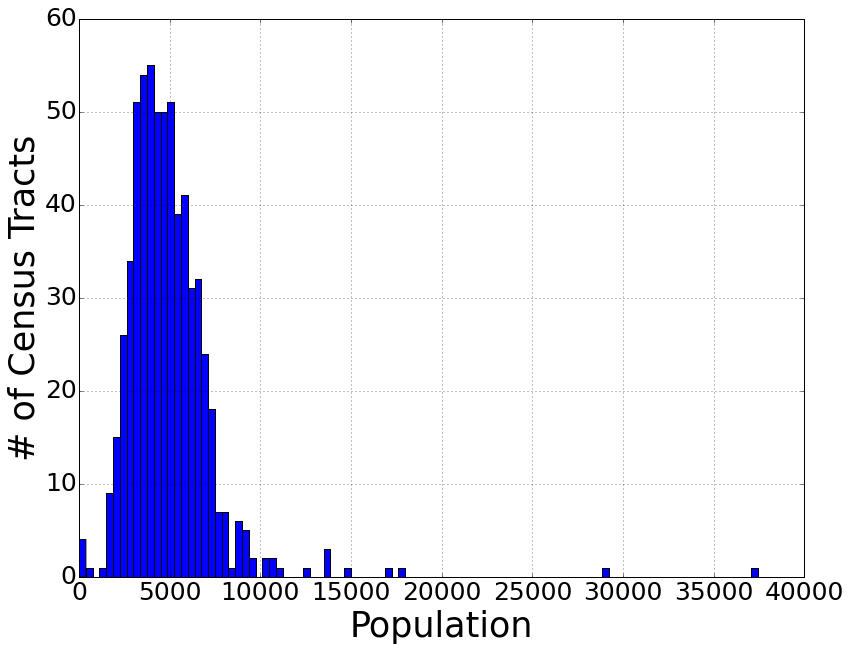

In [12]:
# plot histogram of population per census tract
plt.figure(figsize=(13, 10))
popl.population.hist(bins=100)
plt.xlabel('Population',fontsize=35)
plt.ylabel('# of Census Tracts',fontsize=35)
plt.tick_params(axis='both', which='major', labelsize=25)
print np.mean(popl.population)
print np.median(popl.population)
print np.std(popl.population)

In [13]:
fin[:5]

,homes,homes_percent_mortgage,homes_percent_clear,homes_percent_rent,employment_percent,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter
census_tract,,,,,,,,,,,
100,1397,58.9,23.1,18.0,54.6,106406,115066,27813,1895,1923,1839
201,1047,34.1,11.1,54.8,69.2,97976,157500,42891,1338,2243,974
202,2413,32.7,9.5,57.8,75.0,75019,96000,60116,1559,2026,1445
300,3136,21.5,6.6,71.9,71.2,61679,113047,51125,1394,2310,1282
400,2288,12.2,3.4,84.4,75.4,68488,79911,67693,1299,1870,1255


In [14]:
# join business info, population info, financial info, and parking meter info
features = bus_features.join(popl).join(fin).join(parking_meters).fillna(0)
print features.shape
features[:5]

(314, 46)


,bus_age,n_business,n_businesses_11,n_businesses_21,n_businesses_22,n_businesses_23,n_businesses_31,n_businesses_32,n_businesses_33,n_businesses_42,...,homes_percent_clear,homes_percent_rent,employment_percent,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter,total_amount
census_tract,,,,,,,,,,,,,,,,,,,,,
100,0.541876,133,1.0,0.0,0.0,5.0,0.0,0.0,1.0,4.0,...,23.1,18.0,54.6,106406,115066,27813,1895,1923,1839,0.0
201,0.538251,182,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,...,11.1,54.8,69.2,97976,157500,42891,1338,2243,974,4161773.0
202,0.541876,184,1.0,0.0,0.0,10.0,0.0,0.0,0.0,4.0,...,9.5,57.8,75.0,75019,96000,60116,1559,2026,1445,11290108.0
300,0.486091,493,1.0,0.0,0.0,7.0,2.0,1.0,4.0,2.0,...,6.6,71.9,71.2,61679,113047,51125,1394,2310,1282,68427664.0
400,0.516499,480,0.0,0.0,0.0,4.0,1.0,0.0,1.0,6.0,...,3.4,84.4,75.4,68488,79911,67693,1299,1870,1255,44826639.0


In [15]:
# get min/max of each column
min_cols = np.min(features,axis=0)
max_cols = np.max(features,axis=0)

# save min/max as dataframe
min_max_frame = pd.DataFrame({'min_vals': min_cols.values, 'max_vals': max_cols.values}, index=min_cols.index).T

# write min/max of each column to CSV
min_max_frame.to_csv('data_final/min_max_features.csv', index_label='min_max')
min_max_frame

,bus_age,n_business,n_businesses_11,n_businesses_21,n_businesses_22,n_businesses_23,n_businesses_31,n_businesses_32,n_businesses_33,n_businesses_42,...,homes_percent_clear,homes_percent_rent,employment_percent,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter,total_amount
max_vals,1.0,3281.0,4.0,1.0,8.0,185.0,34.0,40.0,148.0,264.0,...,100.0,100.0,100.0,172846.0,230179.0,188750.0,3688.0,4000.0,2000.0,191205635.0
min_vals,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# feature scale to min/max range
features_scaled = (features-min_cols) / (max_cols-min_cols)
print features_scaled.shape
features_scaled[:10]

(314, 46)


,bus_age,n_business,n_businesses_11,n_businesses_21,n_businesses_22,n_businesses_23,n_businesses_31,n_businesses_32,n_businesses_33,n_businesses_42,...,homes_percent_clear,homes_percent_rent,employment_percent,income_med,income_med_owner,income_med_renter,cost_med,cost_med_owner,cost_med_renter,total_amount
census_tract,,,,,,,,,,,,,,,,,,,,,
100,0.541876,0.040244,0.25,0.0,0.0,0.027027,0.000000,0.000,0.006757,0.015152,...,0.231,0.180,0.372928,0.615612,0.499898,0.147354,0.513829,0.48075,0.9195,0.000000
201,0.538251,0.055183,0.00,0.0,0.0,0.032432,0.000000,0.000,0.006757,0.000000,...,0.111,0.548,0.574586,0.566840,0.684250,0.227237,0.362798,0.56075,0.4870,0.021766
202,0.541876,0.055793,0.25,0.0,0.0,0.054054,0.000000,0.000,0.000000,0.015152,...,0.095,0.578,0.654696,0.434022,0.417067,0.318495,0.422722,0.50650,0.7225,0.059047
300,0.486091,0.150000,0.25,0.0,0.0,0.037838,0.058824,0.025,0.027027,0.007576,...,0.066,0.719,0.602210,0.356844,0.491126,0.270861,0.377983,0.57750,0.6410,0.357875
400,0.516499,0.146037,0.00,0.0,0.0,0.021622,0.029412,0.000,0.006757,0.022727,...,0.034,0.844,0.660221,0.396237,0.347169,0.358638,0.352223,0.46750,0.6275,0.234442
500,0.449023,0.061280,0.00,0.0,0.0,0.027027,0.058824,0.000,0.000000,0.007576,...,0.081,0.652,0.720994,0.317670,0.366111,0.265293,0.331887,0.45475,0.5725,0.011336
600,0.387541,0.076220,0.00,0.0,0.0,0.027027,0.029412,0.000,0.000000,0.011364,...,0.066,0.701,0.689227,0.323496,0.349367,0.281653,0.329718,0.39675,0.5905,0.006188
700,0.446434,0.064939,0.25,0.0,0.0,0.032432,0.058824,0.025,0.006757,0.011364,...,0.052,0.747,0.653315,0.399066,0.505572,0.327974,0.365239,0.60425,0.6205,0.062528
800,0.360758,0.040549,0.00,0.0,0.0,0.016216,0.000000,0.000,0.006757,0.000000,...,0.055,0.712,0.613260,0.261325,0.401084,0.215931,0.296367,0.45200,0.5055,0.007590


In [17]:
# write dataframe to csv
features_scaled.to_csv('data_final/features.csv')